# City of Melbourne Parking Analysis

In this notebook we analyse real time parking data from the City of Melbourne (CoM). We have set up a process using the prefect library to extract real time parking data in 10 minute intervals.

In [991]:
import pandas as pd
import numpy as np
import os
import powerlaw
from datetime import timedelta

In [1457]:
# read all files in data folder
df_array = []
file_count = 0

for _file in os.listdir(r'./data_prep/raw_data'):
    if _file != 'raw_data.7z':
        out = pd.read_csv(r'./data_prep/raw_data/' + _file)
        df_array.append(out)
        file_count += 1

df = pd.concat(df_array)
df.datetime = pd.to_datetime(df.datetime)
df.set_index(['datetime','bay_id'], inplace=True)
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    5236         11526N       0
                    2655         10159W       1
                    2670         10179W       1
                    1274          4466E       0
...                                 ...     ...
2022-01-09 19:10:00 4111          C6374       0
                    2644         10118E       0
                    2684         10193W       0
                    2691         10200E       0
                    950            C806       1

[416824 rows x 2 columns]

In [1459]:
# parking locations which have data for all counts
obs_counts = df.groupby(level = 'bay_id').count()
obs_counts[(obs_counts.status == file_count)].shape[0]

758

In [1460]:
good_bays = obs_counts[(obs_counts.status == file_count)].index.get_level_values('bay_id').unique()
df = df[df.index.get_level_values('bay_id').isin(good_bays)]
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    2655         10159W       1
                    2670         10179W       1
                    4044          C6126       1
                    4257          C6846       0
...                                 ...     ...
2022-01-09 19:10:00 4111          C6374       0
                    2644         10118E       0
                    2684         10193W       0
                    2691         10200E       0
                    950            C806       1

[363840 rows x 2 columns]

In [1461]:
## don't do this here - calculate lag based on prediction gap
# # create dataset
# # variables
# # lagged status
# df.sort_index()
# df['lag1'] = df['status'].groupby(level = 'bay_id').shift(1)
# df['lag2'] = df['status'].groupby(level = 'bay_id').shift(2)
# df['lag3'] = df['status'].groupby(level = 'bay_id').shift(3)
# # neighbouring occupancies (how to find?)
# # restrictions?

# df


We want to build a predictive model of parking in the CoM. We anticipate that we will build this using a classification model, which will classify a parking space as either occupied or not. A likely variable to use in this model will be the lagged values for the parking occupancy (i.e. whether the car space was occupied 10, 20, 30,... minutes ago). We examine various lags below and plot them - looking at the percentage of car spaces that have the same value in different time periods.

We see that as the lag gets larger, the proportion of matching values drops away sharply to flatten out at around 65%. This is interesting given that if the probability of being occupied and unoccupied were equal, we would expect to see this value converge to 50% as the time lag gets larger. As we see it reduce to 65% (approx) it may be that one state is more common than the other.

In [1462]:

out = {'perc':[]}
for i in range(1, 170):
    lagged = df['status'].groupby(level = 'bay_id').shift(i)
    filt = lagged.isna()
    filt_lagged = lagged[~filt]
    filt_curr = df[~filt]
    out['perc'].append(round(100*sum(filt_curr.status == filt_lagged) / filt_curr.shape[0], 1))



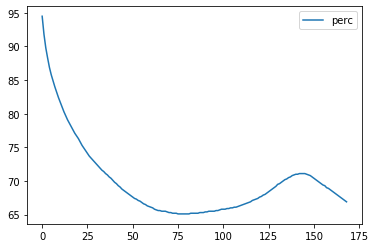

In [1463]:
# seems that closer lags (1 to 5) predict greater than or equal 80% (at this time)
pd.DataFrame(out).plot()

We aggregate all bays across time in df_time and look at the percentage that are occupied. Over time we see that this does not really exceed 45%. It appears that there are generally more unoccupied spots than occupied.
Note that currently this data is extracted for a holiday period during a COVID19 outbreak so this may not reflect normal behaviour - however, it does appear to lend weight to our hypothesis that one parking state is more likely than another. 

To analyse this further we may want to look at whether the occupancy rate varies by location or parking type.

In [1464]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status']].set_index(dates)

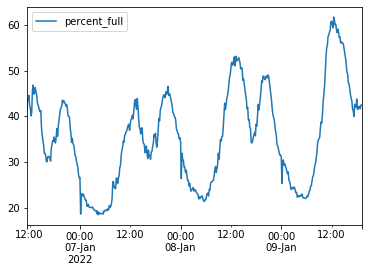

In [1465]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()
    #macro_time_df.loc[date, 'lag1_pred'] = 100*df_time.loc[date, 'lag1'].sum() / df_time.loc[date, 'status'].count()

macro_time_df.plot()

# Parking Restrictions
We can use parking restrictions as features in our model. The permitted parking time and time of restrictions are likely to affect parking turnover. Furthermore, we can know these in advance, so they can add some dynamism to our predictions.

Examining parking restriction data below, we see that there are a variety of different restrictions placed on parking spots. These are also not recorded consistently with day names sometimes abbreviated to a single letter or three letter acronym, and times recorded as single numbers or as a full time.

In [1466]:
# parking restrictions data
park_r = pd.read_csv('./data_prep/datasets/parking_bay_restrictions.csv')
park_r.rename(columns = {'BayID': 'bay_id'}, inplace = True) # for consistency with other datasets
park_r.set_index('bay_id', inplace = True) 
park_r.head()

,DeviceID,Description1,Description2,Description3,Description4,Description5,Description6,DisabilityExt1,DisabilityExt2,DisabilityExt3,...,ToDay3,ToDay4,ToDay5,ToDay6,TypeDesc1,TypeDesc2,TypeDesc3,TypeDesc4,TypeDesc5,TypeDesc6
bay_id,,,,,,,,,,,,,,,,,,,,,
8634,28003,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
8587,27956,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
8498,27876,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
3156,26011,3P MTR M-SAT 7:30-20:30,2P SUN 7:30-18:30,NaN,NaN,NaN,NaN,360,240.0,NaN,...,NaN,NaN,NaN,NaN,3P Meter,2P,NaN,NaN,NaN,NaN
8167,25546,1P M-SUN 7:30-23:00,NaN,NaN,NaN,NaN,NaN,120,NaN,NaN,...,NaN,NaN,NaN,NaN,1P,NaN,NaN,NaN,NaN,NaN


In [1467]:
all_park_df = df.join(park_r, how = 'inner')
all_park_df.Description1.unique()
# restrictions seem to have:
# xP where x is the number of permitted hours (or less - sometimes only minutes - perhaps remove minute parks from dataset)
# sometimes LZ (loading zone) - may want to remove these from the dataset also
# a time and a day window where the restriction applies
# other text codes with unclear meaning - eg MTR, RPA, 1B?
# seems to be inconsistently recorded codes

array(['1P MTR M-F 7:30-18:30', '4P MTR M-F 7:30-18:30',
       '2P TKT A M-SAT 7:30-20:30', '1/2P M-SUN 7:30AM-11PM',
       '1/2P MTR M-SAT 7.30 TO 18.30', '1 PM Mon-Sat 7.30-23.00',
       '1P MTR M-F 7:30-16:00', '1/4P 9.30am-4.30pm M-F',
       '2P MTR RPA M-F 7:30-18:30', '1P MTR M-SAT 7:30-18:30',
       '2P MTR M-SAT 7:30-18:30', '3P MTR M-SAT 7:30-20:30',
       '2P MTR M-SAT 7:30-20:30', '4P MTR M-SAT 7:30-18:30',
       '2P DIS ONLY 7.30 - 20.30', '2P MTR M-F 7:30-18:30',
       '1P RPA M-SUN 7:30-23:00', '1/4P M-F 9:30-16:00',
       '2P M-F 7:30-18:30', 'LZ 30M M-F 7:30-19:30',
       'LZ 15M M-F 7:30-18:30', '4P TKT A M-F 7:30-18:30',
       '4P RPA M-F 7:30-18:30', '3P MTR M-F 10:00-16:00',
       '4P M-F 7:30-18:30', '2P RPA M-F 7:30-18:30',
       'CW TOW M-F 7:00-10:00', '1/4P M-F 7:30-18:30',
       '1/4P M-F 7.30 - 4.30', 'LZ 30MINS -722 - M-F 7.30-19.30',
       'P DIS AOT 20:30 TO 23:59', 'L/Zone 30MINS 7.30 - 6.30PM',
       '1P A RPE M-F 7:30-18:30', '1P M-F 7:3

In [1468]:
all_park_df.TypeDesc1.unique()

array(['1P Meter', '4P Meter', '2P Ticket A', '1/2P', '1/2P Meter',
       '1/4P', '2P Meter', '3P Meter', '2P Disabled Only', '1P', '2P',
       'Loading Zone 30M', 'Loading Zone 15M', '4P Ticket A', '4P',
       'Clearway (Tow away)', 'Loading Zone 30M 722', 'Disabled Only',
       '4P Disabled Only', '1P Disabled Only', '1P Ticket A', 'P 10 Mins',
       '3P Disabled Only', '3P'], dtype=object)

In [1469]:
import re
# pattern = r'\dP'
# [re.match(pattern, desc) for desc in all_park_df.TypeDesc1.unique()]

def extract_hrs(string):
    pattern = r'\dP'
    res = re.match(pattern, string)
    if res:
        return res.group()
    else:
        return '0'

all_park_df.loc[:, 'hours'] = all_park_df.TypeDesc1.apply(lambda x: extract_hrs(x))
all_park_df

st_marker_id  status  DeviceID  \
datetime            bay_id                                  
2022-01-06 11:20:00 2655         10159W       1     25009   
                    2670         10179W       1     23243   
                    4044          C6126       1     29785   
                    4257          C6846       0     24903   
                    3027          5123W       0     26595   
...                                 ...     ...       ...   
2022-01-09 19:10:00 4111          C6374       0     25130   
                    2644         10118E       0     24881   
                    2684         10193W       0     25018   
                    2691         10200E       0     26707   
                    950            C806       1     26528   

                                         Description1           Description2  \
datetime            bay_id                                                     
2022-01-06 11:20:00 2655        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2670        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    4044        4P MTR M-F 7:30-18:30  4P MTR SAT 7:30-12:30   
                    4257    2P TKT A M-SAT 7:30-20:30      2P SUN 7:30-18:30   
                    3027       1/2P M-SUN 7:30AM-11PM                    NaN   
...                                               ...                    ...   
2022-01-09 19:10:00 4111        4P MTR M-F 7:30-18:30  4P MTR SAT 7:30-12:30   
                    2644        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2684        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2691      1P DIS M-SUN 0:00-23:59                    NaN   
                    950       2P MTR M-SAT 7:30-20:30      1P SUN 7:30-18:30   

                           Description3 Description4 Description5  \
datetime            bay_id                                          
2022-01-06 11:20:00 2655            NaN          NaN          NaN   
                    2670            NaN          NaN          NaN   
                    4044            NaN          NaN          NaN   
                    4257            NaN          NaN          NaN   
                    3027            NaN          NaN          NaN   
...                                 ...          ...          ...   
2022-01-09 19:10:00 4111            NaN          NaN          NaN   
                    2644            NaN          NaN          NaN   
                    2684            NaN          NaN          NaN   
                    2691            NaN          NaN          NaN   
                    950             NaN          NaN          NaN   

                           Description6  DisabilityExt1  ...  ToDay4  ToDay5  \
datetime            bay_id                               ...                   
2022-01-06 11:20:00 2655            NaN             120  ...     NaN     NaN   
                    2670            NaN             120  ...     NaN     NaN   
                    4044            NaN             480  ...     NaN     NaN   
                    4257            NaN             240  ...     NaN     NaN   
                    3027            NaN              60  ...     NaN     NaN   
...                                 ...             ...  ...     ...     ...   
2022-01-09 19:10:00 4111            NaN             480  ...     NaN     NaN   
                    2644            NaN             120  ...     NaN     NaN   
                    2684            NaN             120  ...     NaN     NaN   
                    2691            NaN               0  ...     NaN     NaN   
                    950             NaN             240  ...     NaN     NaN   

                            ToDay6         TypeDesc1  TypeDesc2  TypeDesc3  \
datetime            bay_id                                                   
2022-01-06 11:20:00 2655       NaN          1P Meter   1P Meter        NaN   
                   

In [1544]:
from datetime import datetime
def str_24convert(string_time):
    if 'p' in string_time.lower():
        ints = re.split(r'(:|\.|[AaPpMm])', string_time, maxsplit=1)
        ints[0] = str(12 + int(ints[0]))

        return datetime.strptime(''.join(ints).strip().strip(r'[AaPpMm]').replace('.',':'), '%H:%M')
        
    else:

        return datetime.strptime(string_time.strip().strip(r'[AaPpMm]').replace('.',':'), '%H:%M')

def get_time_bracket(string_time):
    pattern = r'\d+(:|.)\d+(AM|am|PM|pm)?(\s?-\s?|\s?TO\s?)\d+(:|.)\d+(AM|am|PM|pm)?'
    res = re.search(pattern, text)
    if res:
        return list(str_24convert(t) for t in re.split(r'-|TO', res.group()))
    else:
        return 0

# pattern = r'\d+(:|.)\d+(AM|am|PM|pm)?(\s?-\s?|\s?TO\s?)\d+(:|.)\d+(AM|am|PM|pm)?'
# #r'\d+(:|.)\d+(AM|am|PM|pm)?(\s?-\s?|\s?TO\s?)\d+(:|.)?\d?(AM|am|PM|pm)?'
# for text in all_park_df.Description1.unique():
    
#     res = re.search(pattern, text)
#     if res:
#         #print(text)
#         print([str_24convert(t) for t in re.split(
#             r'-|TO',res.group())])
#         # print(re.split(
#         #     r'-|TO',res.group())) 
# extract_hrs(x.TypeDesc1)
new_all_park_df = all_park_df.reset_index()         
k = new_all_park_df.apply(lambda x:  1 if x.datetime.between(*get_time_bracket(x.Description1), inclusive = True) else 0, axis =1 )

AttributeError: 'int' object has no attribute 'between'

In [1551]:
all_park_df.iloc[all_park_df.index.get_level_values(0).indexer_between_time('7:00', '9:00')]

st_marker_id  status  DeviceID  \
datetime            bay_id                                  
2022-01-07 07:00:00 4257          C6846       0     24903   
                    2671         10180E       0     24893   
                    6749          6629S       0     29350   
                    4266          C6864       0     24923   
                    4295          C6926       0     24594   
...                                 ...     ...       ...   
2022-01-09 09:00:00 2643         10117W       0     24880   
                    4086          C6286       1     25795   
                    4422          C7684       0     26294   
                    8335         C7736C       0     27279   
                    4069          C6176       0     26935   

                                            Description1  \
datetime            bay_id                                 
2022-01-07 07:00:00 4257       2P TKT A M-SAT 7:30-20:30   
                    2671           1P MTR M-F 7:30-18:30   
                    6749    1/2P MTR M-SAT 7.30 TO 18.30   
                    4266       2P TKT A M-SAT 7:30-20:30   
                    4295       2P TKT A M-SAT 7:30-20:30   
...                                                  ...   
2022-01-09 09:00:00 2643               2P M-F 7:30-18:30   
                    4086           4P MTR M-F 7:30-18:30   
                    4422           4P MTR M-F 7:30-18:30   
                    8335           2P MTR M-F 7:30-18:30   
                    4069           4P MTR M-F 7:30-18:30   

                                          Description2       Description3  \
datetime            bay_id                                                  
2022-01-07 07:00:00 4257             2P SUN 7:30-18:30                NaN   
                    2671             1P SAT 7:30-12:30                NaN   
                    6749    2P MTR M-SAT 18.30 - 20.30  2P SUN 7:30-18:30   
                    4266             2P SUN 7:30-18:30                NaN   
                    4295             2P SUN 7:30-18:30                NaN   
...                                                ...                ...   
2022-01-09 09:00:00 2643             2P SAT 7:30-12:30                NaN   
                    4086         4P MTR SAT 7:30-12:30                NaN   
                    4422             2P SAT 7:30-12:30                NaN   
                    8335         2P MTR SAT 7:30-12:30                NaN   
                    4069         4P MTR SAT 7:30-12:30                NaN   

                           Description4 Description5 Description6  \
datetime            bay_id                                          
2022-01-07 07:00:00 4257            NaN          NaN          NaN   
                    2671            NaN          NaN          NaN   
                    6749            NaN          NaN          NaN   
                    4266            NaN          NaN          NaN   
                    4295            NaN          NaN          NaN   
...                                 ...          ...          ...   
2022-01-09 09:00:00 2643            NaN          NaN          NaN   
                    4086            NaN          NaN          NaN   
                    4422            NaN          NaN          NaN   
                    8335            NaN          NaN          NaN   
                    4069            NaN          NaN          NaN   

                            DisabilityExt1  ...  ToDay4  ToDay5  ToDay6  \
datetime            bay_id                  ...                           
2022-01-07 07:00:00 4257               240  ...     NaN     NaN     NaN   
                    2671               120  ...     NaN     NaN     NaN   
                    6749                60  ...     NaN     NaN     NaN   
                    4266               240  ...     NaN     NaN     NaN   
                    4295               240  ...     NaN     NaN     NaN   
...                        

In [1471]:
## convert to 24 hr time
tests = ['7:30AM', '7:30', '11.00pm', '11.00', '2:00PM']


for t in tests:
    print(str_24convert(t))

print('7:30AM'.strip('AM'))

7:30
7:30
23:00
11:00
14:00
7:30


In [1472]:
# how to extract parking spots with variable times?
# indicator variable indicating permissable hours by time and day
# e.g. 1P, 2P, 3P, 4P - but include indicator values only at time / day
# add available variable - if not loading zone at certain times then 0 etc.
estimation_data


status  1P  2P  3P  4P  time_hour  1  2  3  4  \
datetime            bay_id                                                  
2022-01-07 11:20:00 857          1   0   1   0   0         11  0  0  0  0   
                    863          0   1   0   0   0         11  0  0  0  0   
                    864          0   0   0   0   0         11  0  0  0  0   
                    869          0   0   1   0   0         11  0  0  0  0   
                    873          0   0   0   0   0         11  0  0  0  0   
...                            ...  ..  ..  ..  ..        ... .. .. .. ..   
2022-01-09 15:00:00 8344         1   1   0   0   0         15  0  0  0  0   
                    8345         0   1   0   0   0         15  0  0  0  0   
                    8347         0   0   0   0   0         15  0  0  0  0   
                    8348         1   0   0   0   0         15  0  0  0  0   
                    8890         1   0   1   0   0         15  0  0  0  0   

                            ...  19  20  21  22  23  lag1  lag2  lag3  lag24  \
datetime            bay_id  ...                                                
2022-01-07 11:20:00 857     ...   0   0   0   0   0   1.0   1.0   1.0    0.0   
                    863     ...   0   0   0   0   0   0.0   0.0   0.0    0.0   
                    864     ...   0   0   0   0   0   1.0   1.0   1.0    0.0   
                    869     ...   0   0   0   0   0   0.0   0.0   0.0    1.0   
                    873     ...   0   0   0   0   0   0.0   0.0   0.0    0.0   
...                         ...  ..  ..  ..  ..  ..   ...   ...   ...    ...   
2022-01-09 15:00:00 8344    ...   0   0   0   0   0   1.0   1.0   1.0    1.0   
                    8345    ...   0   0   0   0   0   0.0   0.0   0.0    0.0   
                    8347    ...   0   0   0   0   0   1.0   1.0   1.0    1.0   
                    8348    ...   0   0   0   0   0   1.0   1.0   1.0    1.0   
                    8890    ...   0   0   0   0   0   1.0   1.0   1.0    1.0   

                             changes  
datetime            bay_id            
2022-01-07 11:20:00 857     0.166667  
                    863     0.166667  
                    864     0.166667  
                    869     0.000000  
                    873     0.000000  
...                              ...  
2022-01-09 15:00:00 8344    0.000000  
                    8345    0.000000  
                    8347    0.000000  
                    8348    0.000000  
                    8890    0.000000  

[232939 rows x 34 columns]

In [1473]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
# set up modelling data
estimation_data = all_park_df[['status', 'hours']].copy(deep = True)
dummies = pd.get_dummies(estimation_data.hours, drop_first = True)
estimation_data = estimation_data[['status']].astype(int)
estimation_data = pd.merge(estimation_data, dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

# include hour variable
estimation_data['time_hour'] = estimation_data.index.get_level_values(0).hour
time_dummies = pd.get_dummies(estimation_data.time_hour, drop_first = True)
estimation_data = pd.merge(estimation_data, time_dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

# extract test and train data
most_recent = np.max(estimation_data.index.get_level_values(0))
# how far ahead to predict in minutes
interval = 30
split = most_recent - timedelta(minutes = interval)

# calc appropriate lag
estimation_data['lag1'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10)
estimation_data['lag2'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10 + 1)
estimation_data['lag3'] = estimation_data['status'].groupby(level = 'bay_id').shift(interval / 10 + 2)

# 24 hr lag
estimation_data['lag24'] = estimation_data['status'].groupby(level = 'bay_id').shift(144)

# get single period lag for change calc
estimation_data['changes'] = estimation_data.lag1 != estimation_data.lag2
estimation_data['changes'] = estimation_data.changes.rolling(window = 6).mean()

estimation_data = estimation_data[~(estimation_data.lag1.isna()|estimation_data.lag24.isna()|estimation_data.lag2.isna()|estimation_data.lag3.isna())]

test = estimation_data.loc[(split + timedelta(minutes = 10)):] # retain datetime index
train = estimation_data.loc[:split]

# 'lag1','lag2', 'lag3',
features = ['lag24','lag1','lag2', 'lag3','1P', '2P', '3P', '4P'] + [i for i in range(1, 24)]

X_test = test[features]
Y_test = test['status']
X_train = train[features]
Y_train = train['status']

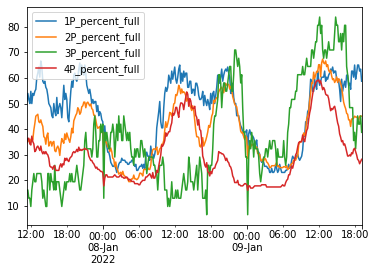

In [1474]:
dates = estimation_data.index.get_level_values(0)
macro_time_df_all = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    for _type in ['1P', '2P', '3P', '4P']:
        date_df = estimation_data.loc[date]
        macro_time_df_all.loc[date, f'{_type}_percent_full'] = 100*date_df.loc[date_df[_type] == 1, 'status'].sum() / date_df.loc[date_df[_type] == 1, 'status'].count()


macro_time_df_all.plot()

In [1409]:
estimation_data.loc['2022-Jan-7 16:30', ['1P', '2P', '3P', '4P']].sum()

1P    126
2P    273
3P     31
4P    231
dtype: int64

In [1437]:
X_train.loc['2022-Jan-8 10:00']

lag24  lag1  lag2  lag3  1P  2P  3P  4P  1  2  \
datetime            bay_id                                                  
2022-01-08 10:00:00 857       1.0   0.0   0.0   0.0   0   1   0   0  0  0   
                    863       0.0   0.0   0.0   0.0   1   0   0   0  0  0   
                    864       1.0   0.0   0.0   0.0   0   0   0   0  0  0   
                    869       0.0   0.0   0.0   0.0   0   1   0   0  0  0   
                    873       0.0   0.0   0.0   0.0   0   0   0   0  0  0   
...                           ...   ...   ...   ...  ..  ..  ..  .. .. ..   
                    8344      1.0   1.0   1.0   1.0   1   0   0   0  0  0   
                    8345      1.0   0.0   0.0   0.0   1   0   0   0  0  0   
                    8347      1.0   1.0   1.0   1.0   0   0   0   0  0  0   
                    8348      1.0   0.0   0.0   0.0   0   0   0   0  0  0   
                    8890      1.0   1.0   1.0   1.0   0   1   0   0  0  0   

                            ...  14  15  16  17  18  19  20  21  22  23  
datetime            bay_id  ...                                          
2022-01-08 10:00:00 857     ...   0   0   0   0   0   0   0   0   0   0  
                    863     ...   0   0   0   0   0   0   0   0   0   0  
                    864     ...   0   0   0   0   0   0   0   0   0   0  
                    869     ...   0   0   0   0   0   0   0   0   0   0  
                    873     ...   0   0   0   0   0   0   0   0   0   0  
...                         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
                    8344    ...   0   0   0   0   0   0   0   0   0   0  
                    8345    ...   0   0   0   0   0   0   0   0   0   0  
                    8347    ...   0   0   0   0   0   0   0   0   0   0  
                    8348    ...   0   0   0   0   0   0   0   0   0   0  
                    8890    ...   0   0   0   0   0   0   0   0   0   0  

[749 rows x 31 columns]

# Modelling

Using the features we have extracted, we now estimate a model which classifies a parking space as occupied or empty.


In [1194]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


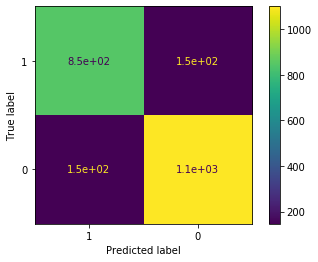

In [1448]:
LR = LogisticRegression(random_state=1)
LR.fit(X_train, Y_train)

pred = LR.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

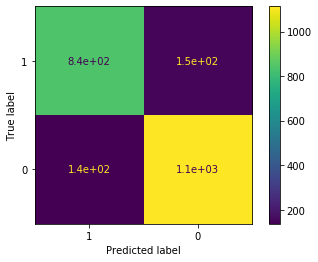

In [1421]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 500, ccp_alpha = 0.1)
rf.fit(X_train, Y_train)

pred = rf.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [1097]:
acc = {'acc': [], 'occ': []}

for date in pd.date_range(split + timedelta(minutes = 10), periods = 6, freq = '10min'):
    pred = LR.predict(X_test.loc[date])
    cm = confusion_matrix(Y_test.loc[date], pred)
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    occupancy = 100* pred.sum() / len(pred)
    acc['acc'].append(accuracy)
    acc['occ'].append(occupancy)
    #ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()


In [1476]:
# running cross validation across all obs
acc = {'acc': [], 'occ': []}

for date in np.unique(estimation_data.index.get_level_values(0)):

    LR.fit(estimation_data.loc[date - np.timedelta64(10, 'm'):, features], estimation_data.loc[date - np.timedelta64(10, 'm'):, 'status'])
    pred = LR.predict(estimation_data.loc[date, features])
    cm = confusion_matrix(estimation_data.loc[date,'status'], pred)
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    occupancy = 100* pred.sum() / len(pred)
    acc['acc'].append(accuracy)
    acc['occ'].append(occupancy)
    #ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [946]:
def combine_preds(X, Y, pred):
    
    curr_date = np.max(X.index.get_level_values(0))
    # get next interval
    next_date = curr_date + timedelta(minutes = 10)

    # update indicies and get new df
    new_date_index = np.tile(next_date, len(pred))
    new_park_index = X.index.get_level_values(1).unique()
    new_multi_index = pd.MultiIndex.from_tuples(list(zip(new_date_index, new_park_index)))

    new_data = pd.DataFrame({'status' : pred}, index = new_multi_index)

    # merge and create combined df
    temp_train = pd.merge(X, Y, left_index = True, right_index = True)
    combined = pd.concat([new_data, temp_train])
    combined.sort_index(inplace = True)

    # update lagged values
    for i in [1,2,3]:

        s = next_date - timedelta(minutes = i*10)
        lag_vals = Y.loc[s, ].to_numpy()
        #print(lag_vals.shape, combined.loc[next_data].shape)
        combined.loc[next_date, f'lag{i}'] = lag_vals
    
    

    return combined

def iterative_forecast(model, X_train, Y_train, X_test, n_ahead):
    train_vars = X_train
    train_target = Y_train
    
    last_date = np.max(X_train.index.get_level_values(0)) 

    test_vars = X_test.loc[last_date + timedelta(minutes = 10),]


    # iterate through dates
    for i in range(1, n_ahead + 1):
        pred = model.predict(test_vars) # already fitted model

        new_data = combine_preds(train_vars, train_target, pred)

        train_target = new_data['status']
        train_vars = new_data[['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]
        test_vars = new_data.loc[last_date + timedelta(minutes = 10 * i),['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]

    return new_data.loc[last_date + timedelta(minutes = 10):,]


#LR.predict(X_test)
#k = combine_preds(X_train, Y_train, LR.predict(X_test))
fcast = iterative_forecast(LR, X_train, Y_train, X_test, 10)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

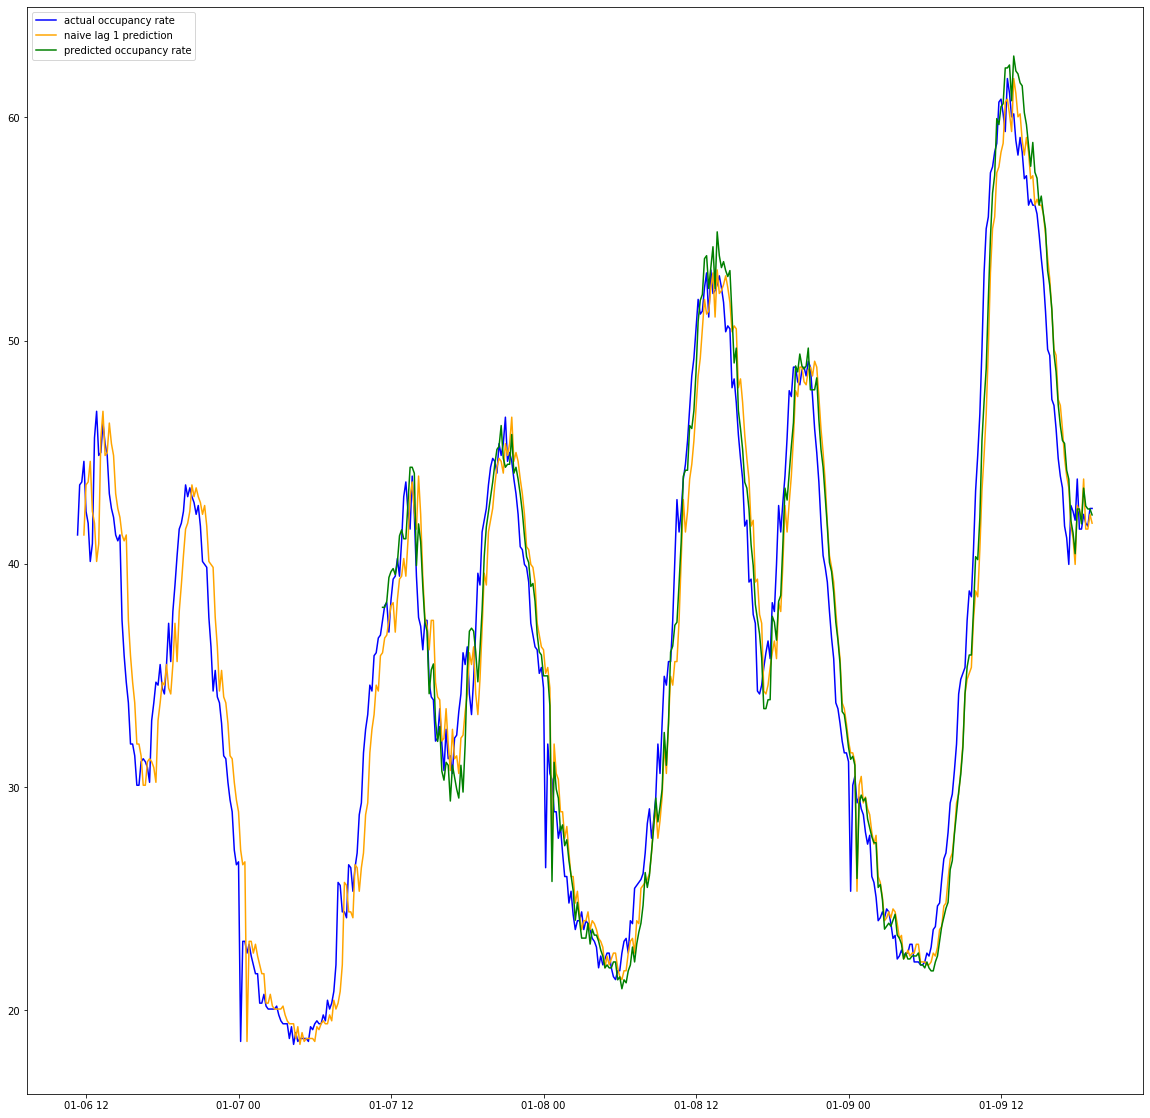

In [1477]:
acc_df = pd.DataFrame(acc, index = np.unique(estimation_data.index.get_level_values(0)))
## analyse the implied occupancy rate
plt.figure(figsize = (20,20))
# does not really provide an advantage over a naive lagged 1 prediction
plt.plot(macro_time_df.loc[:, 'percent_full'], c = 'blue', label = 'actual occupancy rate')
plt.plot(macro_time_df.loc[:, 'percent_full'].shift(3), c = 'orange', label = 'naive lag 1 prediction')
#plt.plot(macro_time_df.loc[:, 'percent_full'].shift(6), c = 'red', label = 'naive lag 6 prediction')
#plt.plot(fcast_occ.index, fcast_occ['percent_full'], 'or', label = 'predicted')
plt.plot(acc_df['occ'].index, acc_df['occ'],'g', label = 'predicted occupancy rate')

plt.legend()
plt.show()


[[ 0.69251465  2.14852119  1.0660335   0.97291481  0.19762481  0.33901014
   1.80783856 -0.07918837  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.02878391 -0.02873506  0.
   0.          0.          0.          0.          0.          0.
   0.        ]]


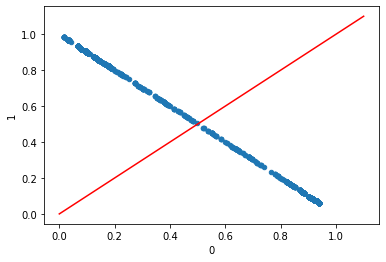

In [1453]:
pd.DataFrame(LR.predict_proba(X_test)).plot(x = 0, y = 1,kind = 'scatter')
plt.plot(np.linspace(0,1.1), np.linspace(0,1.1), c = 'red')
print(LR.coef_)

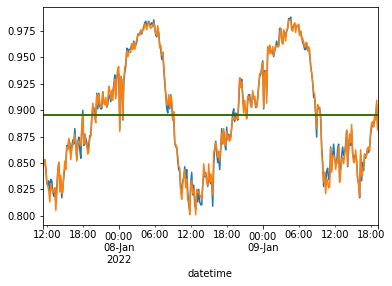

In [1482]:
new = estimation_data.lag1 == estimation_data.status
lag_acc = new.groupby(level = 'datetime').sum() / new.groupby(level = 'datetime').count()
acc_df['acc'].plot()
#(acc_df['occ']/100).plot()
lag_acc.plot()
plt.axhline(acc_df['acc'].mean(), c = 'r')
plt.axhline(lag_acc.mean(), c = 'g')

In [1484]:
print(lag_acc.mean(), acc_df.acc.mean())

0.8953803484010426 0.8956267086273768


In [1431]:
new = estimation_data.lag1 == estimation_data.status
lag_acc = new.groupby(level = 'datetime').sum() / new.groupby(level = 'datetime').count()

datetime
2022-01-07 10:50:00    0.839786
2022-01-07 11:00:00    0.842457
2022-01-07 11:10:00    0.847797
2022-01-07 11:20:00    0.845127
2022-01-07 11:30:00    0.847797
                         ...   
2022-01-09 14:20:00    0.862483
2022-01-09 14:30:00    0.877170
2022-01-09 14:40:00    0.869159
2022-01-09 14:50:00    0.886515
2022-01-09 15:00:00    0.858478
Length: 314, dtype: float64

In [1456]:
print(features,
'\n',
LR.coef_)

['lag24', 'lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 
 [[ 0.69251465  2.14852119  1.0660335   0.97291481  0.19762481  0.33901014
   1.80783856 -0.07918837  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.02878391 -0.02873506  0.
   0.          0.          0.          0.          0.          0.
   0.        ]]


unique_parks

In [1159]:
# count the number of status changes
df['change'] = df.status != df.lag1
changes = df.loc[~df.change.isna(),'change'].groupby(level = 'bay_id').sum()

# can look at changes per hour? changes by area? plot this as a graph?
plt.hist(changes - 1, density = True)

AttributeError: 'DataFrame' object has no attribute 'lag1'

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


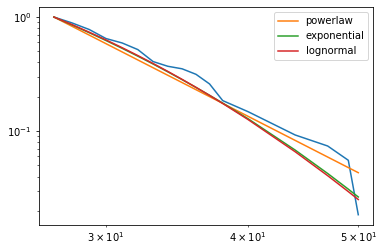

In [338]:

res = powerlaw.Fit(changes - 1)
fig = res.plot_ccdf()
res.power_law.plot_ccdf(ax = fig, label = 'powerlaw')
res.exponential.plot_ccdf(ax = fig, label = 'exponential')
res.lognormal.plot_ccdf(ax = fig, label = 'lognormal')
fig.legend()

In [233]:
# think about:
# what variables do you want for predictions? e.g. lags, neighbouring occupancy, parking restrictions
# what are some overall statistics? e.g. changes per hour, % occupied,% unoccupied (at a time, or in an area or both)
# what sort of model? - thinking classification model, using lags and other variables. start with logisitic regression?


,bay_id,datetime,st_marker_id,status,lag1,lag2,lag3,change
0,4432,2022-01-06 11:20:00,C7704,0,NaN,NaN,NaN,True
1,5236,2022-01-06 11:20:00,11526N,0,NaN,NaN,NaN,True
2,2655,2022-01-06 11:20:00,10159W,1,NaN,NaN,NaN,True
3,2670,2022-01-06 11:20:00,10179W,1,NaN,NaN,NaN,True
4,1274,2022-01-06 11:20:00,4466E,0,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...
119938,2643,2022-01-07 10:30:00,10117W,0,1.0,0.0,0.0,True
119939,4422,2022-01-07 10:30:00,C7684,1,1.0,1.0,1.0,False
119940,4086,2022-01-07 10:30:00,C6286,1,1.0,1.0,1.0,False
119941,8335,2022-01-07 10:30:00,C7736C,0,0.0,0.0,0.0,False


Below we look at the % occupancy of parking spots across the City of Melbourne by time.

In [277]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status', 'lag1', 'lag2', 'lag3']].set_index(dates)

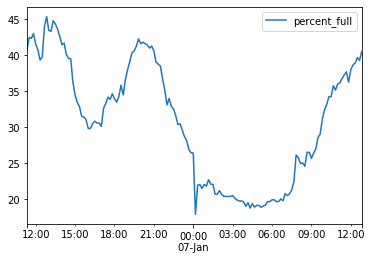

In [278]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()

macro_time_df.plot()

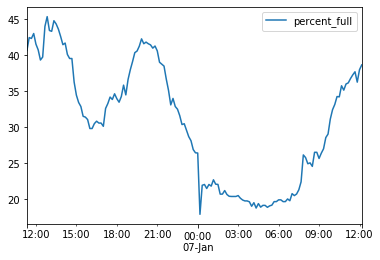